In [1]:
import pandas as pd
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
from curvestat import CurveBoxPlot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["year"] >= 1959) & (billboard_hot_100["year"] <= 2022)]
billboard_hot_100.head()

C:\Users\cutie\AppData\Local\Temp\ipykernel_6732\3421729914.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week


,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year,week
1611,1611,1959-01-12,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,7,Not Listed,Not Listed,Liberty,1959,3
1615,1615,1959-01-05,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,6,Not Listed,Not Listed,Liberty,1959,2
1628,1628,1959-01-12,The Platters,Smoke Gets In Your Eyes,2,2.0,2,9,"O.Harbach, J.Kern",Not Listed,Mercury,1959,3
1629,1629,1959-01-12,Connie Francis,My Happiness,3,6.0,3,6,"B.Bergantine, B.Peterson",Not Listed,MGM,1959,3
1630,1630,1959-01-12,Billy Grammer,Gotta Travel On,4,9.0,4,8,"P.Clayton, L.Ehrlich, R.Gilbert, L.Hays, F.Hel...",Not Listed,Monument,1959,3


In [2]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

plt.rcParams.update({'font.size': 15})

In [3]:
rows_to_add = []

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]
    
    songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10) & ~((billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"])))][["artist", "song_name", "weeks_on_chart",
                "position", "first_day_of_the_week", "year"]]
    grouped = songs_in_decade.groupby(["artist", "song_name"])

    min_first_week = songs_in_decade["first_day_of_the_week"].min().to_pydatetime()

    for name, group in grouped:
        max_week = group["first_day_of_the_week"].max().to_pydatetime()

        for row_index, row in group.iterrows():
            if row["first_day_of_the_week"] == max_week:
                week_date = row["first_day_of_the_week"] + timedelta(weeks=1)

                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": week_date,
                        "year": week_date.year
                    })
                    week_date += timedelta(weeks=1)

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100[["artist", "song_name",
    "weeks_on_chart", "position", "first_day_of_the_week", "year"]], pd.DataFrame(rows_to_add)], ignore_index=True)

In [4]:
billboard_100_with_empty_weeks["first_week"] = billboard_100_with_empty_weeks.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")

## Trajectories overlapped

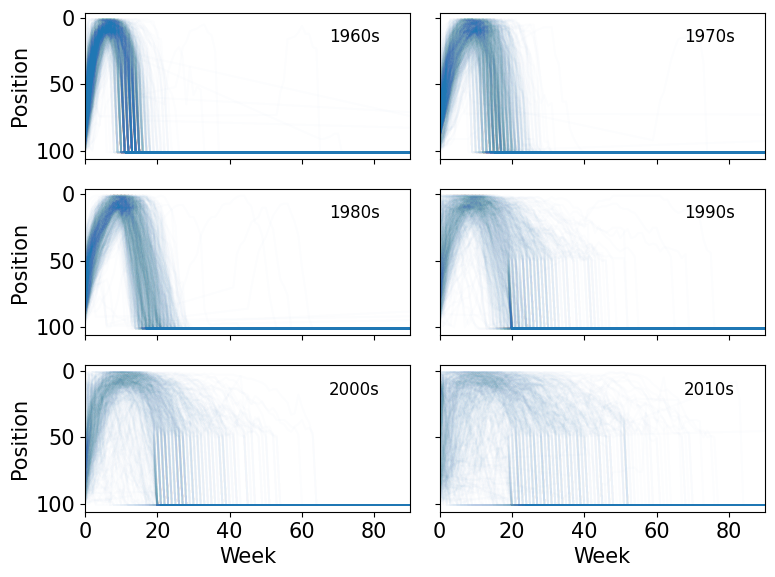

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # take songs that appeared at least once at postion 1-10 in the decade
    top_10_positions_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10) & (billboard_100_with_empty_weeks["position"] >= 1) &\
            (billboard_100_with_empty_weeks["position"] <= 10)][["artist", "song_name"]]
    
    # take songs only from this decade
    top_10_positions_in_decade = top_10_positions_in_decade[~(top_10_positions_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            top_10_positions_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))]
    
    # take all positions of the songs
    top_10_positions_in_decade = top_10_positions_in_decade[["artist", "song_name"]].drop_duplicates().merge(
        billboard_100_with_empty_weeks[["artist", "song_name",
            "position", "first_day_of_the_week", "first_week"]], on=["artist", "song_name"], how="left")

    min_first_week = top_10_positions_in_decade["first_day_of_the_week"].min().to_pydatetime()

    top_10_positions_in_decade["first_day_of_the_week"] = top_10_positions_in_decade.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    top_10_positions_in_decade.set_index("first_day_of_the_week", inplace=True)
    top_10_positions_in_decade.sort_index(inplace=True)

    top_10_positions_in_decade.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[row_i, col_i], alpha=0.01,
        color="C0")

    axes[row_i, col_i].text(0.75, 0.8, f"{year}s", transform=axes[row_i, col_i].transAxes, fontsize=12)

    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim([0, 90])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_1_10_positions_normalized_decades_overlap.pdf", format="pdf")
plt.show()

### For songs that never reached top 50

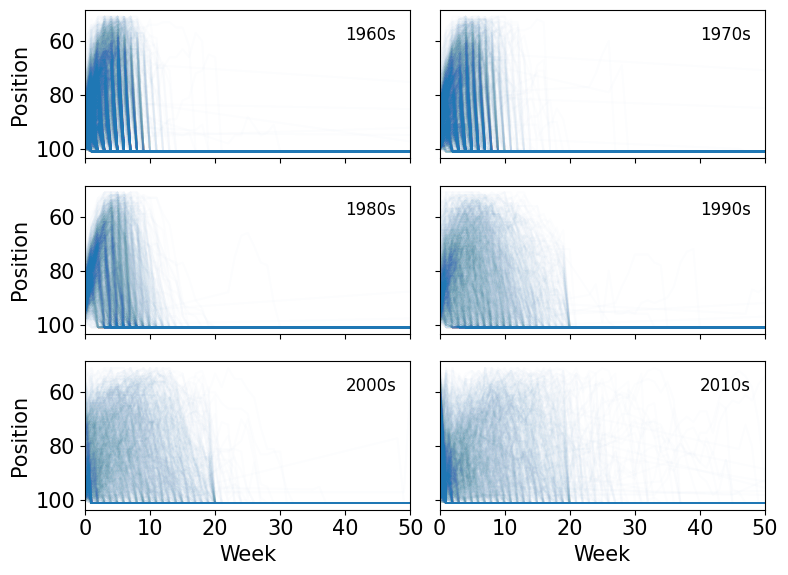

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "position",
            "first_week"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # songs that reached top 50 in the decade
    top_10_positions_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10) & (billboard_100_with_empty_weeks["position"] >= 1) &\
            (billboard_100_with_empty_weeks["position"] <= 50)][["artist", "song_name"]]

    # take songs only from this decade that have never been in top 10
    never_top_10_in_decade = all_songs_in_decade[~(all_songs_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            all_songs_in_decade["song_name"].isin(songs_from_other_decades["song_name"])) &\
                ~(all_songs_in_decade["artist"].isin(top_10_positions_in_decade["artist"]) &\
                    all_songs_in_decade["song_name"].isin(top_10_positions_in_decade["song_name"]))].copy()

    min_first_week = never_top_10_in_decade["first_day_of_the_week"].min().to_pydatetime()

    never_top_10_in_decade["first_day_of_the_week"] = never_top_10_in_decade.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    never_top_10_in_decade.set_index("first_day_of_the_week", inplace=True)
    never_top_10_in_decade.sort_index(inplace=True)

    never_top_10_in_decade.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[row_i, col_i], alpha=0.01,
        color="C0")

    axes[row_i, col_i].text(0.8, 0.8, f"{year}s", transform=axes[row_i, col_i].transAxes, fontsize=12)

    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim([0, 50])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/never_top_1_50_positions_normalized_decades_overlap.pdf", format="pdf")
plt.show()

## Curve-based trajectories statistics

C:\Users\cutie\AppData\Local\Temp\ipykernel_6732\2075988174.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


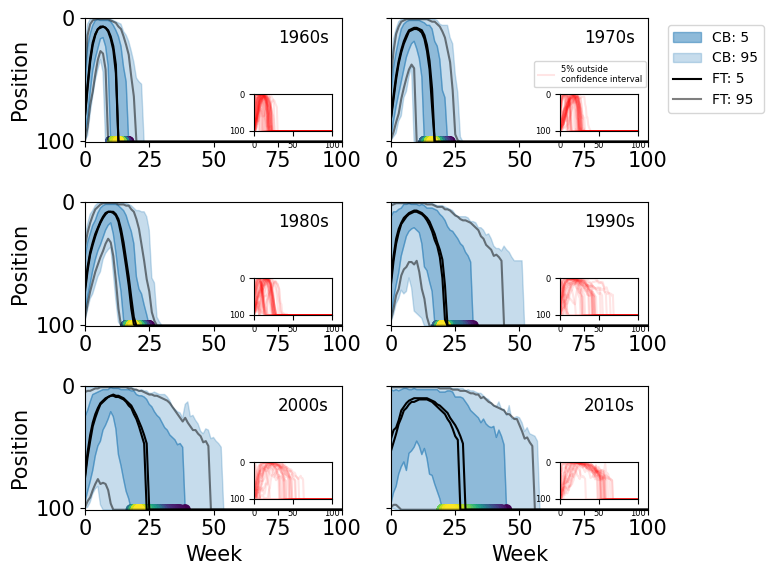

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # take songs that appeared at least once at postion 1-10 in the decade
    top_10_positions_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10) & (billboard_100_with_empty_weeks["position"] >= 1) &\
            (billboard_100_with_empty_weeks["position"] <= 10)][["artist", "song_name"]]
    
    # take songs only from this decade
    top_10_positions_in_decade = top_10_positions_in_decade[~(top_10_positions_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            top_10_positions_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))]
    
    # take all positions of the songs
    top_10_positions_in_decade = top_10_positions_in_decade[["artist", "song_name"]].drop_duplicates().merge(
        billboard_100_with_empty_weeks[["artist", "song_name",
            "position", "first_day_of_the_week", "first_week"]], on=["artist", "song_name"], how="left")

    min_first_week = top_10_positions_in_decade["first_day_of_the_week"].min().to_pydatetime()

    top_10_positions_in_decade["first_day_of_the_week"] = top_10_positions_in_decade.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    top_10_positions_in_decade.set_index("first_day_of_the_week", inplace=True)
    top_10_positions_in_decade.sort_index(inplace=True)

    positions_dict = {}
    positions_array = top_10_positions_in_decade.groupby(["artist", "song_name"])["position"].apply(lambda x: x.values.tolist()).values.tolist()
    for (i, array) in enumerate(positions_array):
        positions_dict[i] = np.append(np.array(array), np.full(522 - len(array), 101))
    last_day_of_data = 522
    time_array = np.arange(0, len(positions_dict[0]), 1)
    
    boxplot = CurveBoxPlot(curves=positions_dict, sample_curves=50, sample_repititions=100, time=time_array)
    
    # workaround: sometimes the sample number of curves results in a singular data covariance matrix
    singular_data_covariance_matrix = True
    while singular_data_covariance_matrix:
        try:
            rank_allornothing = boxplot.rank_allornothing()
            boundaries = boxplot.get_boundaries(rank_allornothing,percentiles=[5, 95])
            heatmapcurves = list(boundaries['curve-based'][5]['curves'])
            heatmap_5 = boxplot.get_peakheatmap(heatmap_curves=heatmapcurves)

            singular_data_covariance_matrix = False
        except np.linalg.LinAlgError:
            singular_data_covariance_matrix = True

    boxplot.plot_everything(ax=axes[row_i, col_i])

    inner_ax = inset_axes(axes[row_i, col_i],
                    width="30%",
                    height="30%",
                    loc=4)
    for curve_nr in positions_dict.keys():
        if curve_nr not in boundaries['curve-based'][95]['curves']:
            inner_ax.plot(time_array, positions_dict[curve_nr], color="red", alpha=0.1)

    inner_ax.set_ylim(101, 0)
    inner_ax.set_xlim([0, 100])
    inner_ax.patch.set_alpha(0.5)
    inner_ax.tick_params(axis='both', which='major', labelsize=6)
    if row_i == 0 and col_i == 1:
        # place the legend above the ax
        inner_ax.legend(["5% outside\nconfidence interval"], fontsize=6, bbox_to_anchor=(1.16, 2))
    axes[row_i, col_i].set_ylim(101, 0)
    if row_i == 0 and col_i == 1:
        axes[row_i, col_i].legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[row_i, col_i].text(0.75, 0.8, f"{year}s", transform=axes[row_i, col_i].transAxes, fontsize=12)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim([0, 100])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.savefig("figures/top_1_10_positions_normalized_decades_curvestat.pdf", format="pdf", bbox_inches="tight")
plt.show()

### For sogns that never reached top 1-50

C:\Users\cutie\AppData\Local\Temp\ipykernel_6732\3630230655.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


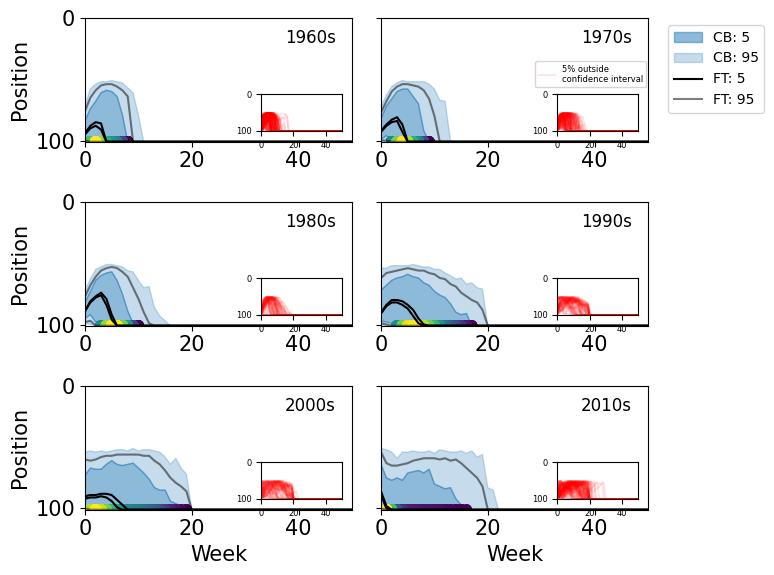

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "position",
            "first_week"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # songs that reached top 50 in the decade
    top_10_positions_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10) & (billboard_100_with_empty_weeks["position"] >= 1) &\
            (billboard_100_with_empty_weeks["position"] <= 50)][["artist", "song_name"]]

    # take songs only from this decade that have never been in top 10
    never_top_10_in_decade = all_songs_in_decade[~(all_songs_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            all_songs_in_decade["song_name"].isin(songs_from_other_decades["song_name"])) &\
                ~(all_songs_in_decade["artist"].isin(top_10_positions_in_decade["artist"]) &\
                    all_songs_in_decade["song_name"].isin(top_10_positions_in_decade["song_name"]))].copy()

    min_first_week = never_top_10_in_decade["first_day_of_the_week"].min().to_pydatetime()

    never_top_10_in_decade["first_day_of_the_week"] = never_top_10_in_decade.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    never_top_10_in_decade.set_index("first_day_of_the_week", inplace=True)
    never_top_10_in_decade.sort_index(inplace=True)

    positions_dict = {}
    positions_array = never_top_10_in_decade.groupby(["artist", "song_name"])["position"].apply(lambda x: x.values.tolist()).values.tolist()
    for (i, array) in enumerate(positions_array):
        positions_dict[i] = np.append(np.array(array), np.full(522 - len(array), 101))
    last_day_of_data = 522
    time_array = np.arange(0, len(positions_dict[0]), 1)
    
    boxplot = CurveBoxPlot(curves=positions_dict, sample_curves=50, sample_repititions=100, time=time_array)
    
    # workaround: sometimes the sample number of curves results in a singular data covariance matrix
    singular_data_covariance_matrix = True
    while singular_data_covariance_matrix:
        try:
            rank_allornothing = boxplot.rank_allornothing()
            boundaries = boxplot.get_boundaries(rank_allornothing, percentiles=[5, 95])
            heatmapcurves = list(boundaries['curve-based'][5]['curves'])
            heatmap_5 = boxplot.get_peakheatmap(heatmap_curves=heatmapcurves)

            singular_data_covariance_matrix = False
        except np.linalg.LinAlgError:
            singular_data_covariance_matrix = True

    boxplot.plot_everything(ax=axes[row_i, col_i])

    inner_ax = inset_axes(axes[row_i, col_i],
                    width="30%",
                    height="30%",
                    loc=4)
    for curve_nr in positions_dict.keys():
        if curve_nr not in boundaries['curve-based'][95]['curves']:
            inner_ax.plot(time_array, positions_dict[curve_nr], color="red", alpha=0.1)

    # inner_ax.set_ylim(101, 0)
    # inner_ax.legend(["5% outside confidence interval"])
    # axes[row_i, col_i].set_ylim(101, 0)
    # axes[row_i, col_i].legend()
    # axes[row_i, col_i].set_title(f"Position change of songs that never reached top 1-50 in {year}s")
    # axes[row_i, col_i].set_xlabel("Week")
    # axes[row_i, col_i].set_ylabel("Position")
    inner_ax.set_ylim(101, 0)
    inner_ax.set_xlim([0, 50])
    inner_ax.patch.set_alpha(0.5)
    inner_ax.tick_params(axis='both', which='major', labelsize=6)
    if row_i == 0 and col_i == 1:
        # place the legend above the ax
        inner_ax.legend(["5% outside\nconfidence interval"], fontsize=6, bbox_to_anchor=(1.16, 2))
    axes[row_i, col_i].set_ylim(101, 0)
    if row_i == 0 and col_i == 1:
        axes[row_i, col_i].legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[row_i, col_i].text(0.75, 0.8, f"{year}s", transform=axes[row_i, col_i].transAxes, fontsize=12)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim([0, 50])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.savefig("figures/never_top_1_50_positions_normalized_decades_curvestat.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Similarities between normalized trajectories for songs that reached top 1-10

### Using Manhattan distance

In [9]:
def manhattan_distance(s1, s2):
    return sum(abs(ch1["position"] - ch2["position"]) for ch1, ch2 in zip(s1, s2))

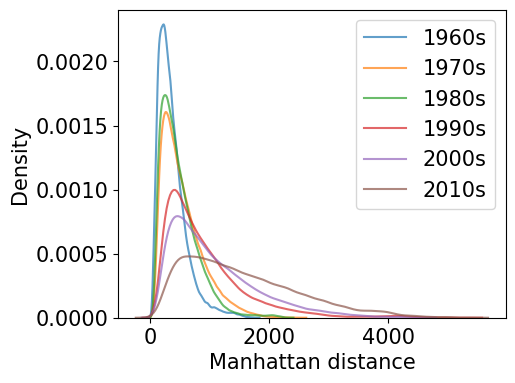

In [10]:
plt.figure(figsize=(5, 4))

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] < year) |\
        (billboard_100_with_empty_weeks["year"] >= year + 10)][["artist", "song_name"]]
    
    # take songs that appeared at least once at postion 1-10 in the decade
    top_10_positions_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10) & (billboard_100_with_empty_weeks["position"] >= 1) &\
            (billboard_100_with_empty_weeks["position"] <= 10)][["artist", "song_name", "weeks_on_chart",
                "position", "first_day_of_the_week", "first_week"]]
                
    # take only songs from this decade
    top_10_positions_in_decade = top_10_positions_in_decade[~(top_10_positions_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            top_10_positions_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))].sort_values(
        by="weeks_on_chart", ascending=False).reset_index()
    
    # take all positions of the songs
    top_10_positions_in_decade = top_10_positions_in_decade[["artist", "song_name"]].drop_duplicates().merge(
        billboard_100_with_empty_weeks[["artist", "song_name",
            "position", "first_day_of_the_week", "first_week"]], on=["artist", "song_name"], how="left")

    min_first_week  = top_10_positions_in_decade["first_day_of_the_week"].min().to_pydatetime()

    top_10_positions_in_decade["first_day_of_the_week"] = top_10_positions_in_decade.apply(lambda row:
        int(((min_first_week + timedelta(days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)
    top_10_positions_in_decade.set_index("first_day_of_the_week", inplace=True)
    top_10_positions_in_decade.sort_index(inplace=True)

    grouped = top_10_positions_in_decade.groupby(["artist", "song_name"])
    rows_to_compare = []
    for name, group in grouped:
        rows_to_compare.append([])
        for row_index, row in group.iterrows():
            rows_to_compare[-1].append({
                    "position": row["position"],
                })

    manhattan_distances = []
    for row1 in rows_to_compare:
        for row2 in rows_to_compare:
            if row1 != row2:
                manhattan_distances.append(manhattan_distance(row1, row2))

    sns.kdeplot(manhattan_distances, label=f'{year}s', alpha=0.7)

plt.xlabel("Manhattan distance")
plt.ylabel("Density")
plt.legend()
plt.savefig("figures/top_1_10_trajectories_similarities_decades_manhattan.pdf", format="pdf", bbox_inches="tight")
plt.show()

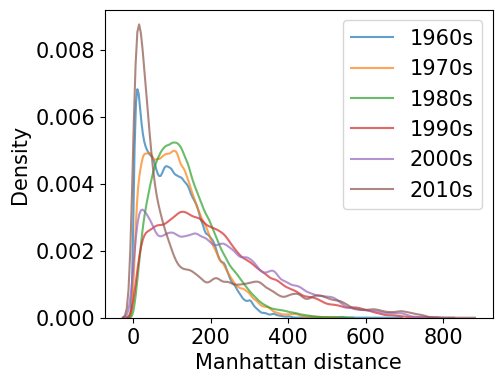

In [11]:
plt.figure(figsize=(5, 4))

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "position",
            "first_week"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # songs that reached top 50 in the decade
    top_10_positions_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10) & (billboard_100_with_empty_weeks["position"] >= 1) &\
            (billboard_100_with_empty_weeks["position"] <= 50)][["artist", "song_name"]]

    # take songs only from this decade that have never been in top 10
    never_top_10_in_decade = all_songs_in_decade[~(all_songs_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            all_songs_in_decade["song_name"].isin(songs_from_other_decades["song_name"])) &\
                ~(all_songs_in_decade["artist"].isin(top_10_positions_in_decade["artist"]) &\
                    all_songs_in_decade["song_name"].isin(top_10_positions_in_decade["song_name"]))].copy()

    min_first_week  = never_top_10_in_decade["first_day_of_the_week"].min().to_pydatetime()

    never_top_10_in_decade["first_day_of_the_week"] = never_top_10_in_decade.apply(lambda row:
        int(((min_first_week + timedelta(days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)
    never_top_10_in_decade.set_index("first_day_of_the_week", inplace=True)

    grouped = never_top_10_in_decade.groupby(["artist", "song_name"])
    rows_to_compare = []
    for name, group in grouped:
        rows_to_compare.append([])
        for row_index, row in group.iterrows():
            rows_to_compare[-1].append({
                    "position": row["position"],
                })

    manhattan_distances = []
    for row1 in rows_to_compare:
        for row2 in rows_to_compare:
            if row1 != row2:
                manhattan_distances.append(manhattan_distance(row1, row2))

    sns.kdeplot(manhattan_distances, label=f'{year}s', alpha=0.7)

plt.xlabel("Manhattan distance")
plt.ylabel("Density")
plt.legend()
plt.savefig("figures/never_top_1_50_trajectories_similarities_decades_manhattan.pdf", format="pdf", bbox_inches="tight")
plt.show()

## CCDFS for distributions

### Position change

In [50]:
grouped = billboard_hot_100.groupby(["artist", "song_name"])
rows_to_add = []
for name, group in grouped:
    max_week = group["first_day_of_the_week"].max()
    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            rows_to_add.append({
                "artist": row["artist"],
                "song_name": row["song_name"],
                "first_day_of_the_week": row["first_day_of_the_week"] + timedelta(weeks=1),
                "position": 101,
                "last_week_position": row["position"],
                "position_rised": 0,
                "weeks_on_chart": row["weeks_on_chart"]
            })

billboard_hot_100_with_disappeared_songs = pd.concat([billboard_hot_100, pd.DataFrame.from_records(rows_to_add)], ignore_index=True)

In [51]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return 100 - position
    return last_week_position - position

billboard_hot_100_with_disappeared_songs["position_change"] = billboard_hot_100_with_disappeared_songs.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

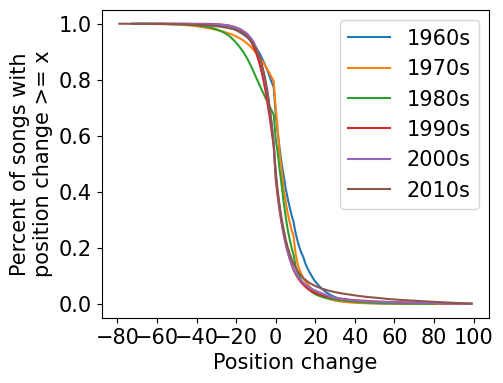

In [65]:
plt.figure(figsize=(5, 4))

billboard_subset = billboard_hot_100_with_disappeared_songs[["year", "first_day_of_the_week", "position_change"]]

for year in range(1960, 2020, 10):
    decade_subset = billboard_subset[(billboard_subset["year"] >= year) &\
        (billboard_subset["year"] < year + 10)]["position_change"]
    count_changes = decade_subset.value_counts().sort_index()

    cdf = count_changes.values.cumsum() / count_changes.values.sum()
    ccdf = 1 - cdf

    plt.plot(count_changes.index, ccdf, label=f"{year}s")

plt.locator_params(axis='x', nbins=10)
plt.legend()
plt.xlabel("Position change")
plt.ylabel("Percent of songs with\nposition change >= x")
plt.savefig("figures/ccdf_position_difference_distribution_decades.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Max weeks on chart

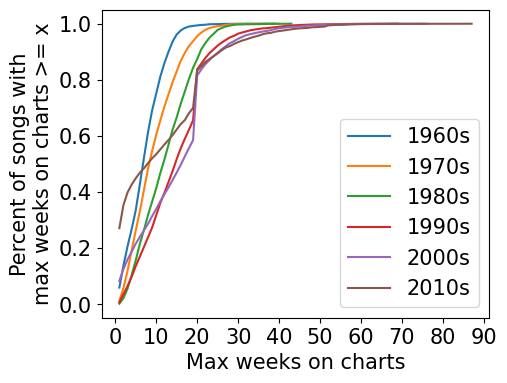

In [64]:
plt.figure(figsize=(5, 4))

for year in range(1960, 2020, 10):
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]]

    max_weeks_on_chart = all_songs_in_decade[["artist", "song_name", "weeks_on_chart"]].groupby(
        by=["artist", "song_name"]).max().reset_index()

    count_weeks = max_weeks_on_chart["weeks_on_chart"].value_counts().sort_index()
    cdf = count_weeks.values.cumsum() / count_weeks.values.sum()
    ccdf = 1 - cdf

    plt.plot(count_weeks.index, cdf, label=f"{year}s")

plt.locator_params(axis='x', nbins=10)
plt.legend()
plt.xlabel("Max weeks on charts")
plt.ylabel("Percent of songs with\nmax weeks on charts >= x")
plt.savefig("figures/ccdf_max_weeks_on_chart_distribution_decades.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Start end positions

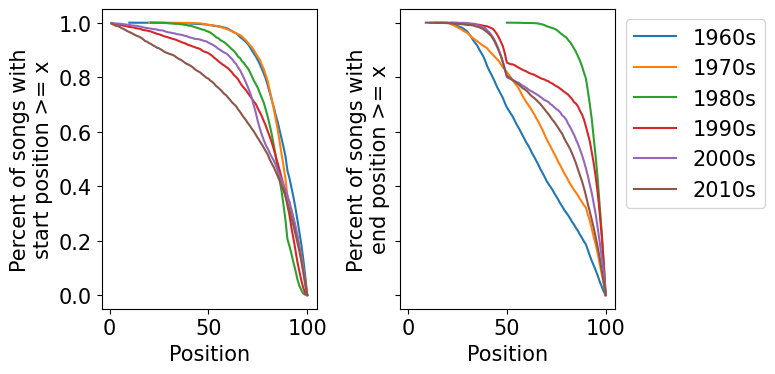

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "position"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    songs_from_decade = all_songs_in_decade[~(all_songs_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            all_songs_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))]

    start_weeks = songs_from_decade.groupby(["artist", "song_name"])["first_day_of_the_week"].min().reset_index()
    end_weeks = songs_from_decade.groupby(["artist", "song_name"])["first_day_of_the_week"].max().reset_index()

    start_positions = start_weeks.drop_duplicates().merge(songs_from_decade, on=["artist", "song_name", "first_day_of_the_week"])["position"]
    end_positions = end_weeks.drop_duplicates().merge(songs_from_decade, on=["artist", "song_name", "first_day_of_the_week"])["position"]

    count_start_positions = start_positions.value_counts().sort_index()
    count_end_positions = end_positions.value_counts().sort_index()

    cdf_start = count_start_positions.values.cumsum() / count_start_positions.values.sum()
    ccdf_start = 1 - cdf_start

    cdf_end = count_end_positions.values.cumsum() / count_end_positions.values.sum()
    ccdf_end = 1 - cdf_end

    axes[0].plot(count_start_positions.index, ccdf_start, label=f"{year}s")
    axes[0].set_xlabel("Position")
    axes[0].set_ylabel("Percent of songs with\nstart position >= x")
    
    axes[1].plot(count_end_positions.index, ccdf_end, label=f"{year}s")
    axes[1].set_xlabel("Position")
    axes[1].set_ylabel("Percent of songs with\nend position >= x")
    axes[1].legend(bbox_to_anchor=(1, 1))

fig.tight_layout()
plt.savefig("figures/ccdf_distribution_start_end_positions_decades.pdf", format="pdf", bbox_inches="tight")
plt.show()